In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
import requests

#On Azure

Cf. https://nbviewer.org/github/microsoft/AIforEarthDataSets/blob/main/data/noaa-hrrr.ipynb :

In [78]:
start_date = date(2020, 11 , 1)
# https://rapidrefresh.noaa.gov/hrrr/ says:
# HRRR implementations at NCEP
#HRRRv1 - 30 Sept 2014
#HRRRv2 - 23 Aug 2016
#HRRRv3 - 12 July 2018
#HRRRv4 - 2 Dec 2020

#start_date = date(2022, 2 , 25)

yesterday = date.today() - timedelta(days=1)
end_date = yesterday
daterange = pd.date_range(start_date, end_date)


In [93]:
# Constants for creating the full URL
# cf. https://github.com/microsoft/AIforEarthDataSets/blob/main/data/noaa-hrrr.md#storage-resources
blob_container = "https://noaahrrr.blob.core.windows.net/hrrr"
sector = "conus" # https://en.wikipedia.org/wiki/Contiguous_United_States 
cycle = 12          # noon

product = "wrfsfcf" # 2D surface levels


# Try requesting the index files for this parameter combination
# with forecast hours 0 and 1
# for each day in the chosen date range:

datestring = dict()
available_noforecast = dict()
available_1hforecast = dict()

for thisdate in daterange:  
  datestring[thisdate] = thisdate.date().strftime('%Y%m%d')
  # print('requesting file(s) for',datestring[thisdate],'...')
  
  forecast_hour = 1   # offset from cycle time
  # Put entire URL together:
  file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
  url = f"{blob_container}/hrrr.{thisdate:%Y%m%d}/{sector}/{file_path}"
  r = requests.get(f"{url}.idx")
  blobnotfound_bool = (r.text.splitlines()[0].find('BlobNotFound') > 0)
  available_1hforecast[thisdate] = 1-int(blobnotfound_bool)

  forecast_hour = 0   # no forecast
  file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
  url = f"{blob_container}/hrrr.{thisdate:%Y%m%d}/{sector}/{file_path}"
  r = requests.get(f"{url}.idx")
  blobnotfound_bool = (r.text.splitlines()[0].find('BlobNotFound') > 0)
  available_noforecast[thisdate] = 1-int(blobnotfound_bool)


df = pd.DataFrame.from_dict(data = available_noforecast, orient='index', columns = ['available_noforecast'])
df = df.join( pd.DataFrame.from_dict(data = available_1hforecast, orient='index', columns = ['available_1hforecast']) )

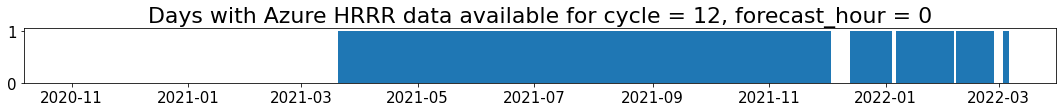

In [94]:
fig, ax = plt.subplots()
ax.bar(df.index, df.available_noforecast, width=1)
ax.xaxis_date()
ax.tick_params(labelsize=15)
ax.set_title('Days with Azure HRRR data available for cycle = 12, forecast_hour = 0', fontsize = 22)
fig.set_size_inches(18.5, 1)
plt.show()

In [102]:
df[(df.index >= pd.Timestamp(date(2021, 3 , 11))) & (df.index <= pd.Timestamp(date(2021, 3 , 31))) ]

,available_noforecast,available_1hforecast
2021-03-11,0,0
2021-03-12,0,0
2021-03-13,0,0
2021-03-14,0,0
2021-03-15,0,0
2021-03-16,0,0
2021-03-17,0,0
2021-03-18,0,0
2021-03-19,0,0
2021-03-20,0,0


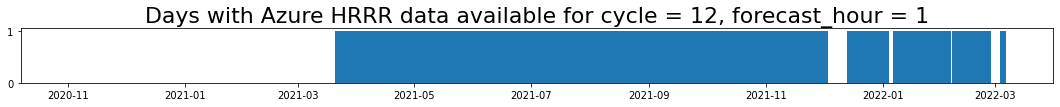

In [103]:
fig, ax = plt.subplots()
ax.bar(df.index, df.available_1hforecast, width=1)
ax.xaxis_date()
ax.set_title('Days with Azure HRRR data available for cycle = 12, forecast_hour = 1', fontsize = 22)
fig.set_size_inches(18.5, 1)
plt.show()

In [6]:
# example from https://github.com/microsoft/AIforEarthDataSets/blob/main/data/noaa-hrrr.md#storage-resources :
url = 'https://noaahrrr.blob.core.windows.net/hrrr/hrrr.20141201/conus/hrrr.t18z.wrfsubhf15.grib2'
r = requests.get(f"{url}.idx")
r.text.splitlines()[0]

'<?xml version="1.0" encoding="utf-8"?><Error><Code>BlobNotFound</Code><Message>The specified blob does not exist.'

#On AWS

https://mesowest.utah.edu/html/hrrr/ : "This archive contains GRIB2 output from the HRRR model beginning on September 30, 2014."

https://registry.opendata.aws/noaa-hrrr-pds/ (same archive)
: "Archive of HRRR data since 2014."

In [89]:
# Constants for creating the full URL
# cf. https://github.com/microsoft/AIforEarthDataSets/blob/main/data/noaa-hrrr.md#storage-resources
# and https://mesowest.utah.edu/html/hrrr/
blob_container = "https://noaa-hrrr-bdp-pds.s3.amazonaws.com"
sector = "conus" # https://en.wikipedia.org/wiki/Contiguous_United_States 
cycle = 12          # noon

product = "wrfsfcf" # 2D surface levels


# Try requesting the index files for this parameter combination
# with forecast hours 0 and 1
# for each day in the chosen date range:

datestring = dict()
available_noforecast = dict()
available_1hforecast = dict()

for thisdate in daterange:  
  datestring[thisdate] = thisdate.date().strftime('%Y%m%d')
  print('requesting file(s) for',datestring[thisdate],'...')
  
  forecast_hour = 1   # offset from cycle time
  # Put entire URL together:
  
  file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
  url = f"{blob_container}/hrrr.{thisdate:%Y%m%d}/{sector}/{file_path}"
  # e.g. https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20210719/conus/hrrr.t00z.wrfsfcf00.grib2.idx
  r = requests.get(f"{url}.idx")
  blobnotfound_bool = (r.text.splitlines()[0].find('BlobNotFound') > 0)
  available_1hforecast[thisdate] = 1-int(blobnotfound_bool)

  forecast_hour = 0   # no forecast
  file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
  url = f"{blob_container}/hrrr.{thisdate:%Y%m%d}/{sector}/{file_path}"
  r = requests.get(f"{url}.idx")
  blobnotfound_bool = (r.text.splitlines()[0].find('BlobNotFound') > 0)
  available_noforecast[thisdate] = 1-int(blobnotfound_bool)


df = pd.DataFrame.from_dict(data = available_noforecast, orient='index', columns = ['available_noforecast'])
df = df.join( pd.DataFrame.from_dict(data = available_1hforecast, orient='index', columns = ['available_1hforecast']) )

requesting file(s) for 20201101 ...
requesting file(s) for 20201102 ...
requesting file(s) for 20201103 ...
requesting file(s) for 20201104 ...
requesting file(s) for 20201105 ...
requesting file(s) for 20201106 ...
requesting file(s) for 20201107 ...
requesting file(s) for 20201108 ...
requesting file(s) for 20201109 ...
requesting file(s) for 20201110 ...
requesting file(s) for 20201111 ...
requesting file(s) for 20201112 ...
requesting file(s) for 20201113 ...
requesting file(s) for 20201114 ...
requesting file(s) for 20201115 ...
requesting file(s) for 20201116 ...
requesting file(s) for 20201117 ...
requesting file(s) for 20201118 ...
requesting file(s) for 20201119 ...
requesting file(s) for 20201120 ...
requesting file(s) for 20201121 ...
requesting file(s) for 20201122 ...
requesting file(s) for 20201123 ...
requesting file(s) for 20201124 ...
requesting file(s) for 20201125 ...
requesting file(s) for 20201126 ...
requesting file(s) for 20201127 ...
requesting file(s) for 20201

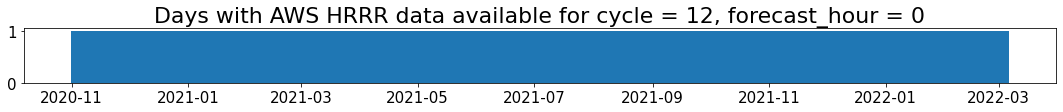

In [91]:
fig, ax = plt.subplots()
ax.bar(df.index, df.available_noforecast, width=1)
ax.xaxis_date()
ax.tick_params(labelsize=15)
ax.set_title('Days with AWS HRRR data available for cycle = 12, forecast_hour = 0', fontsize = 22)
fig.set_size_inches(18.5, 1)
plt.show()

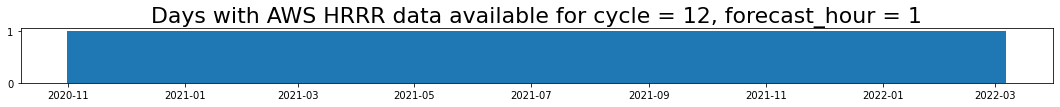

In [92]:
fig, ax = plt.subplots()
ax.bar(df.index, df.available_1hforecast, width=1)
ax.xaxis_date()
ax.set_title('Days with AWS HRRR data available for cycle = 12, forecast_hour = 1', fontsize = 22)
fig.set_size_inches(18.5, 1)
plt.show()